**Cosmological Fitting**

In [ ]:
import numpy as np
import scipy as sp
import astropy as ap

H_0 = 71
c = 3e8

#hubble parameter
def H(z, OmegaM, OmegaLam, w):
  y = H_0 * ((OmegaM * ((1 + z)**3) + OmegaLam * (np.power(1+z,3+3*w))) ** 0.5)
  return np.power(y,-1)

#luminosity distance
def dl(O_lam,O_mass,w,z):
  d = (1+z)*c/1000*sp.integrate.quad(H,0,z,args = (O_mass,O_lam,w))[0]
  return d

#distance modulus
def mu(O_lam,O_mass,w,z):
  mew = 5 * np.log10(dl(O_lam, O_mass, w, z) / (1e-5))
  return mew



Chi square fitting

In [ ]:
import pandas as pd

#reading data file
dat = pd.read_csv('apjab08a0t12_mrt.txt',names=np.linspace(0,61,62,dtype = int),header=126,delim_whitespace='_',usecols=[2,10,11,47,48,49])
dat = pd.DataFrame.to_numpy(dat)
dat_sort = dat[dat[:,1].argsort()]

In [ ]:
#checking chi squares for sanity
chi_matterfull = 0
chi_lambcdm = 0
chi_matterpart = 0
for i in range(len(dat[:,1])):
  chi_matterfull += np.square(dat[i,3] - mu(0,1,0,dat[i,1]))/mu(0,1,0,dat[i,1])
  chi_matterpart += np.square(dat[i,3] - mu(0,0.7,0,dat[i,1]))/mu(0,1,0,dat[i,1])
  chi_lambcdm += np.square(dat[i,3] - mu(0.7,0.3,-1,dat[i,1]))/mu(0.3,0.7,-1,dat[i,1])


print(chi_matterfull,chi_matterpart,chi_lambcdm)

1.698960273774859 1.0424264805640293 0.3871371261597629


In [ ]:
#creating function to be optimized
def chi(x,mu_exp,z):
  chi_val = 0
  for i in range(len(z)):
    chi_val += np.square(mu_exp[i] - mu(x[0],x[1],x[2],z[i]))/mu(x[0],x[1],x[2],z[i])
  return chi_val

In [ ]:
#binning data

for i in range(1,15):
  datasect = dat_sort[47*(i-1):47*i,1:4:2]
  bin = np.array([np.mean(datasect[:,0]),np.mean(datasect[:,1])])
  if i == 1:
    dat_bin = bin
  dat_bin = np.vstack((dat_bin,bin))

print(dat_bin)

[[1.44089362e-02 3.40596043e+01]
 [1.44089362e-02 3.40596043e+01]
 [2.14178723e-02 3.48402723e+01]
 [2.82676596e-02 3.54984766e+01]
 [3.47000000e-02 3.59221809e+01]
 [4.86836170e-02 3.66505489e+01]
 [1.39419362e-01 3.89627638e+01]
 [2.19614894e-01 4.01686426e+01]
 [2.73738298e-01 4.06917298e+01]
 [3.18189362e-01 4.11121809e+01]
 [3.57202128e-01 4.14141660e+01]
 [4.12638298e-01 4.17788553e+01]
 [4.73578723e-01 4.20953404e+01]
 [5.61685106e-01 4.25381447e+01]
 [6.95114894e-01 4.31002574e+01]]


In [ ]:
#defining constraints on optimization
def wcons(x):
  x1,x2,x3 =x
  return x3+1
def omegalambcons(x):
  x1, x2, x3 = x
  return x1
def omegamattcons(x):
  x1, x2, x3 = x
  return x2
def flatcon(x):
  x1, x2, x3 = x
  return x1 + x2 -1

constraints = {'type': 'eq', 'fun': wcons,
               'type': 'ineq', 'fun': omegalambcons,
               'type': 'ineq', 'fun': omegamattcons,
               #'type': 'eq', 'fun': flatcon
               }

#optimizing for minimum chi square value
result = sp.optimize.minimize(chi, x0=[0.7,0.3,-1], args=(dat_bin[:,1],dat_bin[:,0]),constraints=constraints)
print(result.x,chi(result.x,dat[:,3],dat[:,1]))

[ 0.63041174  0.32508661 -0.9548214 ] 0.355497100354225


Text(0, 0.5, '$\\Delta\\mu$')

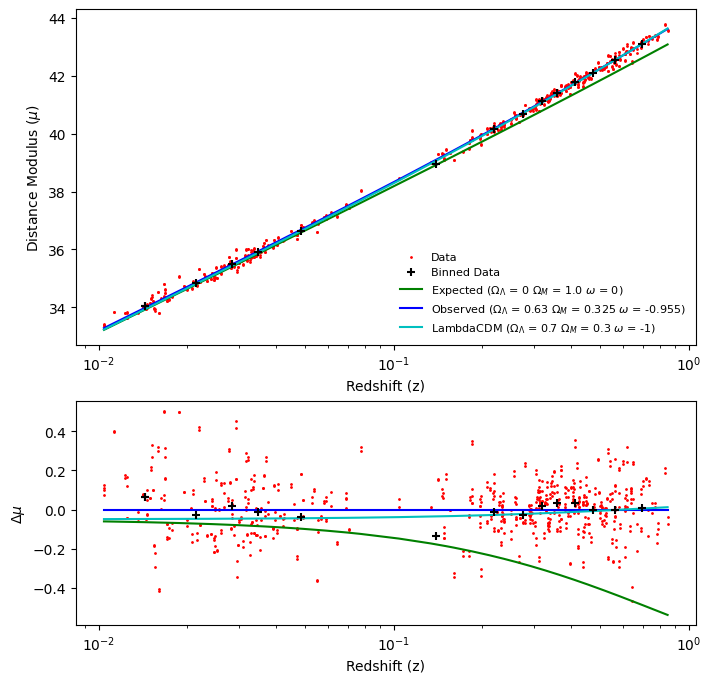

In [ ]:
import matplotlib.pyplot as plt

#generating models
exp = np.array([])
obs = np.array([])
actual = np.array([])
unsorted_obs = np.array([])
z = np.sort(dat[:,1])
for i in range(0,len(z)):
  exp = np.append(exp,mu(0,1,0,z[i]))
  obs = np.append(obs,mu(result.x[0],result.x[1],result.x[2],z[i]))
  actual = np.append(actual,mu(0.7,0.3,-1,z[i]))
  unsorted_obs = np.append(unsorted_obs,mu(result.x[0],result.x[1],result.x[2],dat[i,1]))
obs_bin = np.array([])
for i in range(0,len(dat_bin[:,0])):
  obs_bin = np.append(obs_bin,mu(result.x[0],result.x[1],result.x[2],dat_bin[i,0]))

#plotting
fig,ax = plt.subplots(2,figsize=(8,8),height_ratios=[3,2])
#plotting models against data
ax[0].scatter(dat[:,1],dat[:,3],s=1,c='r',label = 'Data')
ax[0].scatter(dat_bin[:,0],dat_bin[:,1],label = 'Binned Data',marker='+',c='black',zorder=20)
ax[0].plot(z,exp,label = 'Expected ($\Omega_\Lambda$ = 0 $\Omega_{M}$ = 1.0 $\omega$ = 0)',c='g')
label = 'Observed ($\Omega_\Lambda$ = {:.3} $\Omega_M$ = {:.3} $\omega$ = {:.3})'.format(result.x[0],result.x[1],result.x[2])
ax[0].plot(z,obs, label = label,c='b')
ax[0].plot(z,actual,label = 'LambdaCDM ($\Omega_\Lambda$ = 0.7 $\Omega_{M}$ = 0.3 $\omega$ = -1)',c='c')
ax[0].set_xscale('log')
ax[0].legend(loc=4,fontsize=8,frameon=False)
ax[0].set_xlabel('Redshift (z)')
ax[0].set_ylabel('Distance Modulus ($\mu$)')

#plotting residuals
ax[1].scatter(dat[:,1],dat[:,3]-unsorted_obs,s=1,c='r')
ax[1].scatter(dat_bin[:,0],dat_bin[:,1]-obs_bin,label = 'Binned Data',marker='+',c='black',zorder=20)
ax[1].plot(z,exp-obs,label = 'Expected',c='g')
ax[1].plot(z,obs-obs, label = 'Observed',c='b')
ax[1].plot(z,actual-obs,label = 'LambdaCDM',c='c')
ax[1].set_xscale('log')
ax[1].set_xlabel('Redshift (z)')
ax[1].set_ylabel('$\Delta\mu$')